In [1]:
#### DO NOT RUN THIS CODE IN THE NOTEBOOK - copy paste into terminal in the HOME directory!

# git clone https://github.com/tensorflow/models.git

In [2]:
# !pip install s3fs -q
# !pip install tensorflow_hub -q
# !pip install tensorflow_datasets -q
# !pip install pycocotools -q
# !pip install gin-config -q
# !pip install immutabledict -q
# !pip install sentencepiece -q
# !pip install transformers -q
# !pip install evaluate -q
# !pip install sacrebleu -q
# !pip install bert_score -q
# !pip install sentence-transformers -q
# !pip install keras-nlp -q
# !pip install tensorflow-model-optimization -q
# !pip install pyarrow fastparquet -q
# !pip install -r official/projects/movinet/requirements.txt -q

In [3]:
import configparser

config = configparser.ConfigParser()
config.read('/home/ec2-user/.aws/credentials')

['/home/ec2-user/.aws/credentials']

In [4]:
# AWS credentials and S3 settings
aws_access_key_id = config["default"]['aws_access_key_id']
aws_secret_access_key = config["default"]['aws_secret_access_key']
bucket_name = 'asl-capstone'
s3_URI = 's3://asl-capstone/'

In [5]:
import s3fs
fs = s3fs.S3FileSystem(key=aws_access_key_id, secret=aws_secret_access_key)

import boto3
s3 = boto3.client('s3',aws_access_key_id = aws_access_key_id, aws_secret_access_key = aws_secret_access_key,
                  region_name = 'us-west-2')


In [6]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from tqdm import tqdm
from typing import List, Tuple
import matplotlib.pyplot as plt


# import evaluate
# import tensorflow_model_optimization as tfmot

from sklearn.model_selection import train_test_split

tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(2)
tf.keras.backend.clear_session()

2023-12-04 18:24:55.467396: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 18:24:56.168117: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
# !export XLA_PYTHON_CLIENT_PREALLOCATE=false
# !export XLA_FLAGS="--xla_gpu_strict_conv_algorithm_picker=false --xla_gpu_force_compilation_parallelism=1"

In [8]:
# Load model directly
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM, TFT5ForConditionalGeneration #, TFT5EncoderModel
# from transformers.modeling_tf_outputs import TFBaseModelOutputWithPastAndCrossAttentions

# with tf.device("/GPU:0"):
tokenizer = AutoTokenizer.from_pretrained("t5-base")
model = TFAutoModelForSeq2SeqLM.from_pretrained("deanna-emery/ASL_t5_word_epoch15_1204")
    # encoder_model = T5EncoderModel.from_pretrained("google/t5-v1_1-large")

model.trainable = True

# tokenizer = AutoTokenizer.from_pretrained("t5-large")
# model = TFT5ForConditionalGeneration.from_pretrained("t5-large")
# encoder_model = T5EncoderModel.from_pretrained("t5-large")

ENCODER_DIM = 768
# ENCODER_DIM = 1024


model.summary()

/opt/tensorflow/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5_fast.py:158: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
2023-12-04 18:25:00.193382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See 

Model: "tft5_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  24674304  
                                                                 
 encoder (TFT5MainLayer)     multiple                  109628544 
                                                                 
 decoder (TFT5MainLayer)     multiple                  137949312 
                                                                 
Total params: 222903552 (850.31 MB)
Trainable params: 222903552 (850.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
model.trainable = True

# for i in range(3):
#     model.encoder.block[-(i+3)].trainable = False

# for i in range(10):
#     model.encoder.block[-(i+1)].trainable = False

model.summary()

Model: "tft5_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  24674304  
                                                                 
 encoder (TFT5MainLayer)     multiple                  109628544 
                                                                 
 decoder (TFT5MainLayer)     multiple                  137949312 
                                                                 
Total params: 222903552 (850.31 MB)
Trainable params: 222903552 (850.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
wlasl_files = pd.read_parquet("s3://asl-capstone/wlasl/video_mappings_masterfile.parquet"
                             ).rename(columns={'rgb_path':'path', 'word':'caption'})
wlasl_files.path = 's3://' + wlasl_files.path

msasl_files = pd.read_parquet("s3://asl-capstone/msasl/video_mappings_masterfile.parquet")

video_files = pd.concat([wlasl_files, msasl_files], axis=0)

# video_files = pd.read_parquet("s3://asl-capstone/youtube-asl/test_sample/numpy_files/RGB/masterfile.parquet")
video_files = video_files.drop_duplicates().reset_index(drop=True)
video_files['movinet_path'] = video_files.path.str.replace("/RGB/", '/movinet_embedding/')
video_files['caption_cleaned'] = video_files.caption.str.lower().str.replace(r'\[*\]', ' ').str.replace('\n',' ').str.replace('  ',' ').str.replace('...','. ').str.replace('..','.').str.replace('♪', '').str.replace('♫','').str.replace('#','').str.strip(' ')

video_files = video_files[video_files['caption_cleaned']!='']
video_files = video_files[video_files['caption_cleaned']!='.']

print(video_files.shape)
video_files.head()

(25479, 7)


,path,padded_path,caption,frame_count,label_num,movinet_path,caption_cleaned
0,s3://asl-capstone/wlasl/RGB/viewpoint_0.npy,asl-capstone/wlasl/padded/viewpoint_0.npy,viewpoint,93.0,1892.0,s3://asl-capstone/wlasl/movinet_embedding/view...,viewpoint
1,s3://asl-capstone/wlasl/RGB/viewpoint_1.npy,asl-capstone/wlasl/padded/viewpoint_1.npy,viewpoint,82.0,1892.0,s3://asl-capstone/wlasl/movinet_embedding/view...,viewpoint
2,s3://asl-capstone/wlasl/RGB/viewpoint_2.npy,asl-capstone/wlasl/padded/viewpoint_2.npy,viewpoint,40.0,1892.0,s3://asl-capstone/wlasl/movinet_embedding/view...,viewpoint
3,s3://asl-capstone/wlasl/RGB/viewpoint_3.npy,asl-capstone/wlasl/padded/viewpoint_3.npy,viewpoint,81.0,1892.0,s3://asl-capstone/wlasl/movinet_embedding/view...,viewpoint
4,s3://asl-capstone/wlasl/RGB/viewpoint_4.npy,asl-capstone/wlasl/padded/viewpoint_4.npy,viewpoint,111.0,1892.0,s3://asl-capstone/wlasl/movinet_embedding/view...,viewpoint


In [11]:
wl = fs.ls('s3://asl-capstone/wlasl/movinet_embedding/')
wl = ['s3://' + file for file in wl]

ms = fs.ls('s3://asl-capstone/msasl/movinet_embedding/')
ms = ['s3://' + file for file in ms]


s3_files = wl + ms
print(s3_files[0])
len(s3_files)

s3://asl-capstone/wlasl/movinet_embedding/


25762

In [12]:
video_files = video_files[video_files['movinet_path'].isin(s3_files)]
print(video_files.shape)
video_files.head()

(25474, 7)


,path,padded_path,caption,frame_count,label_num,movinet_path,caption_cleaned
0,s3://asl-capstone/wlasl/RGB/viewpoint_0.npy,asl-capstone/wlasl/padded/viewpoint_0.npy,viewpoint,93.0,1892.0,s3://asl-capstone/wlasl/movinet_embedding/view...,viewpoint
1,s3://asl-capstone/wlasl/RGB/viewpoint_1.npy,asl-capstone/wlasl/padded/viewpoint_1.npy,viewpoint,82.0,1892.0,s3://asl-capstone/wlasl/movinet_embedding/view...,viewpoint
2,s3://asl-capstone/wlasl/RGB/viewpoint_2.npy,asl-capstone/wlasl/padded/viewpoint_2.npy,viewpoint,40.0,1892.0,s3://asl-capstone/wlasl/movinet_embedding/view...,viewpoint
3,s3://asl-capstone/wlasl/RGB/viewpoint_3.npy,asl-capstone/wlasl/padded/viewpoint_3.npy,viewpoint,81.0,1892.0,s3://asl-capstone/wlasl/movinet_embedding/view...,viewpoint
4,s3://asl-capstone/wlasl/RGB/viewpoint_4.npy,asl-capstone/wlasl/padded/viewpoint_4.npy,viewpoint,111.0,1892.0,s3://asl-capstone/wlasl/movinet_embedding/view...,viewpoint


<Axes: >

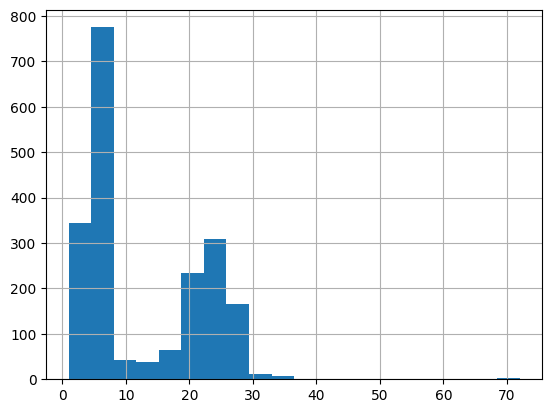

In [13]:
# video_files[(video_files['caption_cleaned'].str.len() > 40) & (video_files['caption_cleaned'].str.len() < 60)].caption_cleaned.unique()

video_files['caption_cleaned'].value_counts().hist(bins=20)

In [14]:
### Start at training mini model to convert from to correct shape for T5
# # Loss function: CosineSimilarity.
# # Minimize for cosine sim between avg label emb and avg vid emb (after flattening)?
# vid_labels = tokenizer(video_files['caption_cleaned'].to_list(), return_tensors="tf", padding=True)
# label_embeds = model.encoder.embed_tokens(vid_labels.input_ids)
# label_embeds_avg = tf.math.reduce_mean(label_embeds, axis=1)

In [15]:
train_files, test_files = train_test_split(video_files, train_size=0.8, random_state=210)
test_files, val_files = train_test_split(test_files, train_size=0.9, random_state=210)

# train_files = train_files.sample(10)
# test_files = test_files.sample(10)
# val_files = val_files.sample(16)



print(train_files.shape)
print(test_files.shape)
print(val_files.shape)

(20379, 7)
(4585, 7)
(510, 7)


In [101]:
def data_generator(file_paths_df, n_frames=256):
    for _, row in file_paths_df.iterrows():
        try:
            with fs.open(row['movinet_path'], 'rb') as f:
                vid_embedding = np.load(f)[0] #.astype(np.float16)
    
            
            if vid_embedding.shape[0] < n_frames:
                # for shorter frame lengths, pad with zeros
                padding = tf.zeros((tf.constant(n_frames) - vid_embedding.shape[0], 
                                    vid_embedding.shape[1]))
                
                attention_mask = tf.concat([tf.ones(vid_embedding.shape[0]), 
                                            tf.zeros(tf.constant(n_frames) - vid_embedding.shape[0])], 
                                           axis=0)
                
                vid_embedding = tf.concat([vid_embedding, padding], axis=0)
                
            # elif vid_embedding.shape[0] > n_frames:
            #     # for longer frame lengths, interpolate
            #     vid_embedding = vid_embedding[:n_frames]
            #     attention_mask = tf.ones(vid_embedding.shape[0])
            
            else:
                # for exactly right size, just output attention_mask
                vid_embedding = vid_embedding[:n_frames]
                attention_mask = tf.ones(vid_embedding.shape[0])
            
            
            label = tokenizer(row['caption_cleaned'], return_tensors="tf", 
                               padding='max_length', max_length=4, truncation=True).input_ids[0]
            # label = row['caption']
            
            yield {'inputs_embeds':vid_embedding, #'input_ids':None, 'training':True,
                   'attention_mask':attention_mask, 'labels':label}
        except:
            print(row['movinet_path'])


In [102]:
# Create TensorFlow Dataset for model input. 
N_FRAMES = 256

train_dataset = tf.data.Dataset.from_generator(
    generator=lambda: data_generator(train_files, n_frames=N_FRAMES),
    output_signature=({'inputs_embeds':tf.TensorSpec(shape=(N_FRAMES, ENCODER_DIM), dtype=tf.float32),
                       'attention_mask':tf.TensorSpec(shape=(N_FRAMES), dtype=tf.float32), 
                       'labels':tf.TensorSpec(shape=(4), dtype=tf.int32)}
                       ))

test_dataset = tf.data.Dataset.from_generator(
    generator=lambda: data_generator(test_files, n_frames=N_FRAMES),
    output_signature=({'inputs_embeds':tf.TensorSpec(shape=(N_FRAMES, ENCODER_DIM), dtype=tf.float32),
                       'attention_mask':tf.TensorSpec(shape=(N_FRAMES), dtype=tf.float32), 
                       'labels':tf.TensorSpec(shape=(4), dtype=tf.int32)}
                       ))

eval_dataset = tf.data.Dataset.from_generator(
    generator=lambda: data_generator(val_files, n_frames=N_FRAMES),
    output_signature=({'inputs_embeds':tf.TensorSpec(shape=(N_FRAMES, ENCODER_DIM), dtype=tf.float32),
                       'attention_mask':tf.TensorSpec(shape=(N_FRAMES), dtype=tf.float32), 
                       'labels':tf.TensorSpec(shape=(4), dtype=tf.int32)}
                       ))

In [103]:
from transformers.keras_callbacks import KerasMetricCallback, PushToHubCallback
from sentence_transformers import SentenceTransformer, util
import evaluate


# push_to_hub_callback = PushToHubCallback(
#     output_dir="./t5_movinet_word", tokenizer=tokenizer, hub_model_id="deanna-emery/ASL_t5_movinet"
# )


bleu = evaluate.load("sacrebleu")
# bertscore = evaluate.load("bertscore",device="cpu")
# st_sim = SentenceTransformer('all-mpnet-base-v2',device="cpu")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    
    if isinstance(preds, tuple):
        preds = preds[0]

    # Decode tokens to words
    preds = np.where(preds >= 0, preds, tokenizer.pad_token_id)
    labels = np.where(labels >= 0, labels, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # # Create SentenceTransformer embeddings from words
    # st_preds = st_sim.encode(decoded_preds)
    # st_labels = st_sim.encode(decoded_labels)

    # # Calculate cosine similarity
    # cos_sim = []
    # for p, l in zip(st_preds, st_labels):
    #     cos_sim.append(float(util.cos_sim(p, l)))

    # Calculate BLEU and BERT score
    result_1 = bleu.compute(predictions=decoded_preds, references=decoded_labels)
    # result_2 = bertscore.compute(predictions=decoded_preds, references=decoded_labels, lang="en", device="cpu")

    # Store results to dcit
    result = {"bleu": result_1["score"]}
    # result['avg_bertscore_f1'] = np.mean(result_2['f1'])
    # result['avg_sent_trans_sim'] = np.median(cos_sim)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, 
                                      eval_dataset=eval_dataset.batch(16,drop_remainder=True),
                                      batch_size=16,
                                      predict_with_generate=True,
                                      generate_kwargs={'max_new_tokens':2, 
                                                       'temperature':0.1,
                                                       'no_repeat_ngram_size':2,
                                                          'do_sample':True,
                                                          'top_k':50, 
                                                          'top_p':0.90,
                                                          # 'early_stopping':True,
                                                      }
                                     )


In [104]:
# # FIGURE OUT OPTIMIZER FOR t5

NUM_EPOCHS = 1
BATCH_SIZE = 32
VAL_BATCH_SIZE = 32

train_steps = len(train_files) // BATCH_SIZE
total_train_steps = train_steps * NUM_EPOCHS

test_steps = len(test_files) // VAL_BATCH_SIZE

# Set learning rate scheduler, optimizer, and loss function
initial_learning_rate = 1e-4
learning_rate = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps=total_train_steps, warmup_target=1e-4, warmup_steps=50
)
# learning_rate = 1e-4

optimizer = tf.keras.optimizers.Adafactor(learning_rate=learning_rate)

loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(
                from_logits=True)

metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1, name='top_1'), 
           tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5') ]

model.compile(optimizer=optimizer, metrics=metrics) 
#loss=model.hf_compute_loss

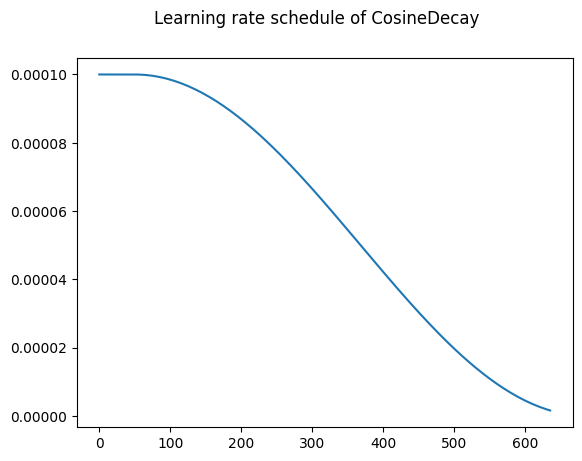

In [105]:
%matplotlib inline

def visualize_lr_schedule(opt, n_steps, step_s) -> Tuple[List[int], List[float]]:
    """Visualize tensorflow keras scheduler learning rate over the course of n_steps training steps.

    Args:
        opt (LearningRateSchedule): learning rate scheduler to be visualized.
        n_steps (int): number of training steps to visualize over.
        step_s (int): sampling step of the training steps, i.e. takes each step_s in the interval [0, n_steps].

    Returns:
        Tuple[List[int], List[float]]: returns x (steps), y (lr values) values of the plot.
    """
    lr = []
    steps = list(range(0, n_steps, step_s))

    for step in steps:
        lr_at_s = opt(step).numpy()
        lr.append(lr_at_s)

    plt.suptitle(f'Learning rate schedule of {type(opt).__name__}')
    plt.plot(steps, lr)

    return steps, lr


steps, lr_values = visualize_lr_schedule(learning_rate, n_steps=total_train_steps, step_s=5)

In [106]:
%%time

# with tf.device("/GPU:0"):
history = model.fit(train_dataset.batch(BATCH_SIZE,drop_remainder=True), 
                    validation_data=test_dataset.batch(VAL_BATCH_SIZE,drop_remainder=True),
                    batch_size = BATCH_SIZE,
                    validation_batch_size = VAL_BATCH_SIZE,
                    epochs=NUM_EPOCHS, 
                    # predict_with_generate = True,
                    # steps_per_epoch=train_steps,
                    # validation_steps=test_steps,
                    callbacks=[metric_callback],
                    verbose=1)

    636/Unknown - 2201s 3s/step - loss: 0.5558 - top_1: 0.8937 - top_5: 0.9350

2023-12-05 05:04:54.496103: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 5438381295401843877
2023-12-05 05:04:54.496151: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 4311245560202368675
2023-12-05 05:04:54.496164: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 3534788911567751085
2023-12-05 05:04:54.496175: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 16666481914579238456
2023-12-05 05:04:54.496422: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 1450015875536862740
2023-12-05 05:12:32.907725: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 12082930278474236161
2023-12-05 05:12:32.907769: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv i

636/636 [==============================] - 2715s 4s/step - loss: 0.5558 - top_1: 0.8937 - top_5: 0.9350 - val_loss: 0.7283 - val_top_1: 0.8737 - val_top_5: 0.9161 - bleu: 0.0000e+00 - gen_len: 2.0000
CPU times: user 9min 21s, sys: 1min 45s, total: 11min 7s
Wall time: 45min 14s


In [115]:
predictions = []
labels = []

for batch in test_dataset.batch(32):
    try:
        test_outputs = model.generate(inputs_embeds = batch['inputs_embeds'], 
                                      attention_mask=batch['attention_mask'],  
                                      max_new_tokens=128, 
                                      temperature=0.01,
                                      # num_beams=2, 
                                      no_repeat_ngram_size=2,
                                      do_sample=True,
                                      top_k=50, 
                                      top_p=0.90, # try 0.5 and 0.2
                                      # early_stopping=True,
                                     ) 
    
        pred = tokenizer.batch_decode(test_outputs, skip_special_tokens=True)
        label = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)
    
        predictions += pred
        labels += label
    except:
        pass

In [116]:
for batch in eval_dataset.batch(32):
    try:
        test_outputs = model.generate(inputs_embeds = batch['inputs_embeds'], 
                                      attention_mask=batch['attention_mask'],  
                                      max_new_tokens=128, 
                                      temperature=0.01,
                                      # num_beams=2, 
                                      no_repeat_ngram_size=2,
                                      do_sample=True,
                                      top_k=50, 
                                      top_p=0.90, # try 0.5 and 0.2
                                      # early_stopping=True,
                                     ) 
    
        pred = tokenizer.batch_decode(test_outputs, skip_special_tokens=True)
        label = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)
    
        predictions += pred
        labels += label
    except:
        pass

In [117]:
from sklearn.metrics import accuracy_score

accuracy_score(labels, predictions)

0.5048086359175662

In [110]:
bleu.compute(predictions=predictions, references=labels)

{'score': 0.0,
 'counts': [2622, 45, 1, 0],
 'totals': [5182, 88, 3, 0],
 'precisions': [50.59822462369741, 51.13636363636363, 33.333333333333336, 0.0],
 'bp': 0.9982647261660741,
 'sys_len': 5182,
 'ref_len': 5191}

In [72]:
word_pred = pd.DataFrame({'caption':labels, 'prediction':predictions})
word_pred.to_parquet("s3://asl-capstone/t5_movinet_epoch17_1204.parquet")

In [36]:
!huggingface-cli whoami
# model = TFAutoModelForSeq2SeqLM.from_pretrained("deanna-emery/ASL_t5_word_epoch15_1204")


# model.save_pretrained("/home/ec2-user/ASL-Translator/modeling/t5_word_epoch12_1203")
model.push_to_hub("deanna-emery/ASL_t5_movinet", revision="words_epoch17_1204")
# trainer.save_model("path/to/model")

# test = TFT5ForConditionalGeneration.from_pretrained("/home/ec2-user/ASL-Translator/modeling/t5_i3d_epoch5_1201")


tf_model.h5:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

In [33]:
# Try training on just WLASL and MSASL

inputs = next(iter(train_dataset.batch(10)))
test_outputs = model.generate(inputs_embeds = inputs['inputs_embeds'], attention_mask=inputs['attention_mask'],  
                              max_new_tokens=128, 
                              # num_beams=2, 
                              no_repeat_ngram_size=2,
                              do_sample=True,
                              top_k=80, 
                              top_p=0.90, # try 0.5 and 0.2
                              # early_stopping=True,
                             ) # TOP-K TOP-P

predictions = tokenizer.batch_decode(test_outputs, skip_special_tokens=True)
test_labels = tokenizer.batch_decode(inputs['labels'], skip_special_tokens=True)

for pred, lab in zip(predictions, test_labels):
    print('prediction: ', pred)
    print('true label: ', lab)
    print('')

prediction:  i will show you the step by step process that goes into picking out and cleaning your trophy case.
true label:  they're very sharp.

prediction:  you want to look for something that can be easily maneuvered through, and if you're not familiar with that type of climbing you can always call an experienced professional to come to your aid.
true label:  then go back in and massage it into your scalp cause you are going to want to moisturize your hair.

prediction:  and, that's going to be our last line in this little story.
true label:  let us talk about oily skin first.

prediction:  you want to always make sure that your kite has an approved service contract with your mechanic so that you can be sure you get the job done right the first time.
true label:  now, slowly begin to connect these movements, exhaling as you drop the chin toward the chest and inhaling as the ear rolls up towards the shoulder blades, and do this as long as you're comfortable.

prediction:  we all need

In [27]:
# # training
# inputs = tokenizer("The <extra_id_0> walks in <extra_id_1> park", return_tensors="tf").input_ids
# labels = tokenizer("<extra_id_0> cute dog <extra_id_1> the <extra_id_2>", return_tensors="tf").input_ids
# outputs = model(inputs, labels=labels)
# loss = outputs.loss
# logits = outputs.logits
# print(loss)
# print(logits)

# # inference
# inputs = tokenizer(
#    [ "studies have shown that owning a cat is good for you", "i have always wanted to have a pet"], return_tensors="pt", padding=True
# ).input_ids  # Batch size 1

# # Convert from tokens to embeddings
# encoder_outputs = encoder_model(input_ids=inputs)
# encoder_outputs['last_hidden_state'] = encoder_outputs['last_hidden_state'].detach().numpy()
# print(encoder_outputs['last_hidden_state'].shape)

# # Generate text from embeddings
# outputs = model.generate(encoder_outputs=encoder_outputs)
# # outputs = model.generate(inputs)


# print("Response: \n")
# print(tokenizer.batch_decode(outputs, skip_special_tokens=True))
# # studies have shown that owning a dog is good for you

In [31]:
# # training
# embeddings = tf.convert_to_tensor(vid_embedding)
# mask = tf.convert_to_tensor(attention_mask)

# labels = tokenizer(captions, return_tensors="tf", padding=True).input_ids
# outputs = model(input_ids=None, inputs_embeds=embeddings, 
#                      attention_mask=mask, labels=labels, training=True)
# print(outputs.loss)
# # loss = outputs.loss
# # logits = outputs.logits
# # print(loss)
# # print(logits)

In [21]:
# model.generate(encoder_outputs=encoder_outputs)
# tokenizer.decode(model.generate(inputs_embeds=encoder_outputs)[0], skip_special_tokens=True)

/opt/tensorflow/lib/python3.10/site-packages/transformers/generation/tf_utils.py:838: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length.  recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
2023-11-08 04:39:47.301175: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55703850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-08 04:39:47.301212: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2023-11-08 04:39:47.408791: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-08 04:39:47.854060: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8903
2023-11-08 04:39:48.206243: I ./tensorflow/compiler/jit/device_compiler.h:186]

's its its it so it. so when it so it so it so it'

In [ ]:
# def movinet_T5_model(video_base_model, language_base_model,
#                       max_sequence_length=120,
#                       hidden_size = 1024,
#                       dropout=0.1,
#                       learning_rate=0.00005):
#     """
#     Builds a translation model that accepts videos, creates video embeddings using a MoViNet model,
#     and then passes the video embeddings into an encoder-decoder to generate text translation
#     """

#     # Set all models to trainable
#     video_base_model.trainable = True
#     language_base_model.trainable = True

#     # Set input structure for video inputs
#     video_inputs = tf.keras.layers.Input(shape=(max_sequence_length, 256, 256, 3), dtype=tf.int64, name='input_layer')
#     # token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
#     attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

#     # Get output embeddings from video model
#     movinet_out = video_base_model(video_inputs)
#     vid_embedding = movinet_out[0]['block4_layer3']

#     # Layer to flatten w x h x c dimensions
#     vid_embedding_flatten = tf.keras.layers.Reshape((120, 8 * 8 * 168), name='flatten')(vid_embedding)

#     # Hidden layer to force embeddings into correct shape for language model
#     vid_embedding_flatten = tf.keras.layers.Dense(1024, activation='linear', name='hidden_layer')(vid_embedding_flatten)

#     # # Pass embeddings into T5 language model
#     # language_output = language_base_model.generate(encoder_outputs=encoder_outputs, attention_mask=attention_mask)

#     # classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

#     # classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

#     # classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#     #                              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
#     #                              metrics='accuracy')



#     ### END YOUR CODE

#     model = tf.keras.Model(inputs=inputs, outputs=vid_embedding_flatten)

#     return model